# Pipeline 3: Species Classification

This pipeline creates a dataset for plant species classification.

Goal: Balance all species classes to ~1000 samples each for better training.

Note: This includes BOTH healthy and diseased plants (we only care about the species).

## Step 1: Configuration Setup

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import re
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load environment variables from the parent directory
env_path = Path.cwd().parent / '.env'
load_dotenv(dotenv_path=env_path)

# Project root is one level up from notebooks/
PROJECT_ROOT = Path.cwd().parent

def make_absolute(path_str):
    """Convert relative path from .env to absolute path."""
    path = Path(path_str)
    return path.resolve() if path.is_absolute() else (PROJECT_ROOT / path).resolve()

# Dataset paths
TRAIN_LABELS_CSV = make_absolute(os.getenv('TRAIN_LABELS_CSV'))
TEST_LABELS_CSV = make_absolute(os.getenv('TEST_LABELS_CSV'))
TRAIN_IMAGES_DIR = make_absolute(os.getenv('TRAIN_IMAGES_DIR'))
TEST_IMAGES_DIR = make_absolute(os.getenv('TEST_IMAGES_DIR'))

# Output paths for SPECIES classification
OUTPUT_SPECIES_BASE_DIR = PROJECT_ROOT / 'dataset' / 'species'
OUTPUT_SPECIES_IMAGES_TRAIN = OUTPUT_SPECIES_BASE_DIR / 'images' / 'train'
OUTPUT_SPECIES_IMAGES_VAL = OUTPUT_SPECIES_BASE_DIR / 'images' / 'val'
OUTPUT_SPECIES_LABELS_TRAIN = OUTPUT_SPECIES_BASE_DIR / 'labels' / 'train'
OUTPUT_SPECIES_LABELS_VAL = OUTPUT_SPECIES_BASE_DIR / 'labels' / 'val'

# Plant species
PLANT_SPECIES = [s.strip() for s in os.getenv('PLANT_SPECIES').split(',')]

# Configuration
TARGET_SAMPLES_PER_CLASS = 1000

print("✓ Configuration loaded!")
print(f"\nProject root: {PROJECT_ROOT}")
print(f"Output: {OUTPUT_SPECIES_BASE_DIR}")
print(f"Target samples per class: {TARGET_SAMPLES_PER_CLASS}")
print(f"Number of species: {len(PLANT_SPECIES)}")

✓ Configuration loaded!

Project root: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection
Output: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/species
Target samples per class: 1000
Number of species: 13


## Step 2: Load and Clean Data

In [2]:
# Load data
df_train = pd.read_csv(TRAIN_LABELS_CSV)
df_test = pd.read_csv(TEST_LABELS_CSV)

print(f"Loaded: {len(df_train)} train, {len(df_test)} test samples")

# Clean class names
for df in [df_train, df_test]:
    df['class'] = (
        df['class']
        .str.replace(r'(?i)leaf', '', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace(r'_', ' ', regex=True)
        .str.strip()
    )

print("✓ Class names cleaned")

Loaded: 8469 train, 452 test samples
✓ Class names cleaned


## Step 3: Extract Features

In [3]:
def extract_species(text):
    for plant in PLANT_SPECIES:
        if re.search(rf"\b{plant}\b", text, flags=re.IGNORECASE):
            return plant
    return None

def extract_disease(text):
    for plant in PLANT_SPECIES:
        text = re.sub(rf"\b{plant}\b", "", text, flags=re.IGNORECASE).strip()
    return text if text else "healthy"

# Extract features
df_train['species'] = df_train['class'].apply(extract_species)
df_train['disease'] = df_train['class'].apply(extract_disease)
df_test['species'] = df_test['class'].apply(extract_species)
df_test['disease'] = df_test['class'].apply(extract_disease)

print("✓ Features extracted")
print(df_train[['class', 'species', 'disease']].head())

✓ Features extracted
    class species  disease
0  Cherry  Cherry  healthy
1  Cherry  Cherry  healthy
2  Cherry  Cherry  healthy
3  Cherry  Cherry  healthy
4   Peach   Peach  healthy


## Step 4: Fix Zero Dimensions

In [4]:
def fix_zero_dimensions(df, image_folder):
    image_folder = Path(image_folder)
    for idx, row in df.iterrows():
        if row['width'] == 0 or row['height'] == 0:
            image_path = image_folder / row['filename']
            if image_path.exists():
                with Image.open(image_path) as img:
                    w, h = img.size
                    df.at[idx, 'width'] = w
                    df.at[idx, 'height'] = h
    return df

df_train = fix_zero_dimensions(df_train, TRAIN_IMAGES_DIR)
df_test = fix_zero_dimensions(df_test, TEST_IMAGES_DIR)
print("✓ Dimensions fixed")

✓ Dimensions fixed


## Step 5: Verify Files Exist

In [5]:
def verify_files_exist(df, image_folder):
    image_folder = Path(image_folder)
    existing_mask = []
    for _, row in df.iterrows():
        existing_mask.append((image_folder / row['filename']).exists())
    return df[existing_mask].copy()

df_train = verify_files_exist(df_train, TRAIN_IMAGES_DIR)
df_test = verify_files_exist(df_test, TEST_IMAGES_DIR)
print(f"✓ Verified: {len(df_train)} train, {len(df_test)} test samples")

✓ Verified: 8461 train, 452 test samples


## Step 6: Filter Out Samples Without Species

In [6]:
# Keep only samples with valid species
df_species = df_train[df_train['species'].notna()].copy()
df_test_species = df_test[df_test['species'].notna()].copy()

print(f"Original training samples: {len(df_train)}")
print(f"Samples with valid species: {len(df_species)}")
print(f"Removed samples without species: {len(df_train) - len(df_species)}")

print(f"\nTest samples with valid species: {len(df_test_species)}")

Original training samples: 8461
Samples with valid species: 8461
Removed samples without species: 0

Test samples with valid species: 452


## Step 7: Analyze Species Distribution

Species distribution (before balancing):
  Tomato: 2740 samples
  Blueberry: 827 samples
  Peach: 610 samples
  Apple: 563 samples
  Potato: 561 samples
  Bell Pepper: 561 samples
  Corn: 550 samples
  Raspberry: 539 samples
  Strawberry: 462 samples
  Grape: 330 samples
  Squash: 251 samples
  Soyabean: 246 samples
  Cherry: 221 samples


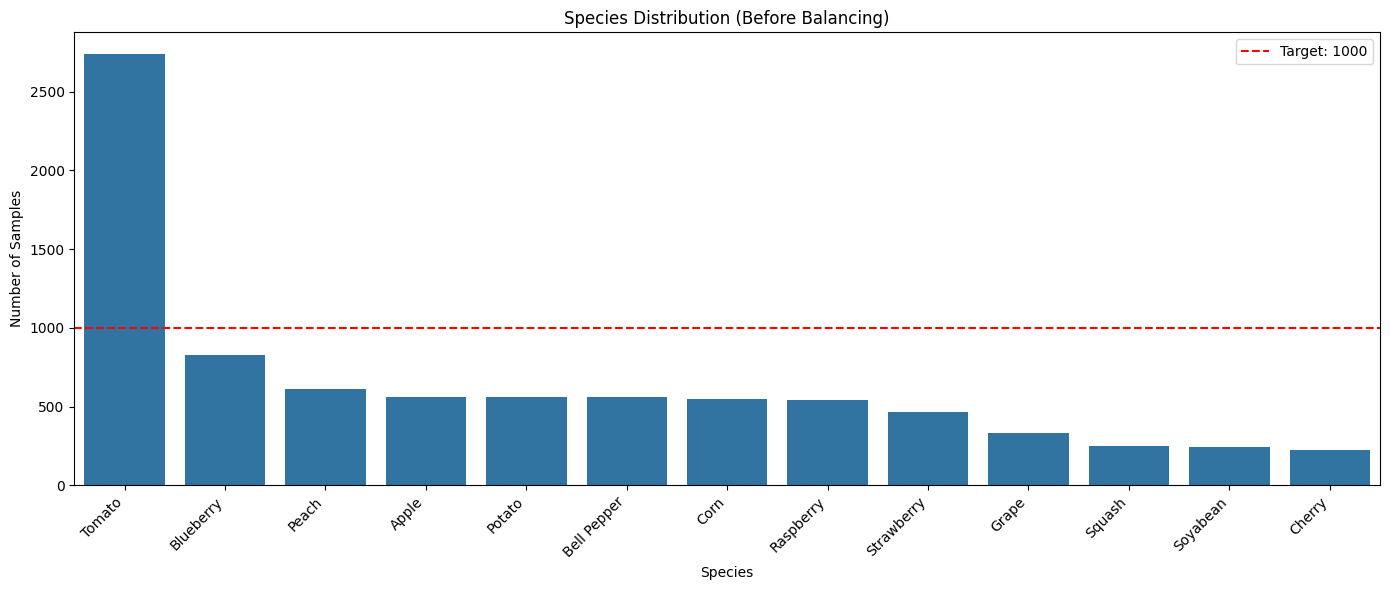

In [7]:
species_counts = df_species['species'].value_counts()

print("Species distribution (before balancing):")
for species, count in species_counts.items():
    print(f"  {species}: {count} samples")

# Visualize
plt.figure(figsize=(14, 6))
sns.barplot(x=species_counts.index, y=species_counts.values)
plt.axhline(y=TARGET_SAMPLES_PER_CLASS, color='r', linestyle='--', label=f'Target: {TARGET_SAMPLES_PER_CLASS}')
plt.title('Species Distribution (Before Balancing)')
plt.xlabel('Species')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Step 8: Balance Species Classes via Duplication

In [ ]:
balanced_dfs = []

# IMPORTANT: Only balance TRAINING data, not test data
for species, group in df_species.groupby("species"):
    n_samples = len(group)
    n_to_add = TARGET_SAMPLES_PER_CLASS - n_samples

    if n_to_add > 0:
        print(f"\n{species}: {n_samples} → {TARGET_SAMPLES_PER_CLASS} (adding {n_to_add} duplicates)")

        # Keep original samples
        balanced_dfs.append(group)

        # Add duplicates with modified filenames
        duplicates_added = 0
        while duplicates_added < n_to_add:
            # Cycle through samples
            idx = duplicates_added % n_samples
            sample = group.iloc[idx:idx+1].copy()

            # Modify filename to avoid conflicts
            original_filename = sample['filename'].values[0]
            stem = Path(original_filename).stem
            suffix = Path(original_filename).suffix
            new_filename = f"{stem}_dup{duplicates_added}{suffix}"
            sample['filename'] = new_filename

            balanced_dfs.append(sample)
            duplicates_added += 1
    else:
        print(f"\n{species}: {n_samples} (already >= target, keeping all)")
        # Keep only up to target to avoid over-representation
        balanced_dfs.append(group)

# Combine all balanced TRAINING data
df_balanced = pd.concat(balanced_dfs, ignore_index=True)

print(f"\n✓ TRAINING dataset balanced!")
print(f"  Total samples: {len(df_balanced)}")

print(f"\n✓ TEST dataset (validation, unbalanced):")
print(f"  Total samples: {len(df_test_species)}")
print(f"\nTest species distribution:")
for species in sorted(df_test_species['species'].unique()):
    count = len(df_test_species[df_test_species['species'] == species])
    print(f"  {species}: {count} samples")


Apple: 563 → 1000 (adding 437 duplicates)

Bell Pepper: 561 → 1000 (adding 439 duplicates)

Blueberry: 827 → 1000 (adding 173 duplicates)

Cherry: 221 → 1000 (adding 779 duplicates)

Corn: 550 → 1000 (adding 450 duplicates)

Grape: 330 → 1000 (adding 670 duplicates)

Peach: 610 → 1000 (adding 390 duplicates)

Potato: 561 → 1000 (adding 439 duplicates)

Raspberry: 539 → 1000 (adding 461 duplicates)

Soyabean: 246 → 1000 (adding 754 duplicates)

Squash: 251 → 1000 (adding 749 duplicates)

Strawberry: 462 → 1000 (adding 538 duplicates)

Tomato: 2740 (already >= target, keeping all)

✓ TRAINING dataset balanced!
  Total samples: 14740

✓ TEST dataset (validation, unbalanced):
  Total samples: 452

Test species distribution:
  Apple: 34 samples
  Bell Pepper: 26 samples
  Blueberry: 22 samples
  Cherry: 19 samples
  Corn: 26 samples
  Grape: 23 samples
  Peach: 10 samples
  Potato: 27 samples
  Raspberry: 17 samples
  Soyabean: 20 samples
  Squash: 6 samples
  Strawberry: 30 samples
  Toma

## Step 9: Visualize Balanced Distribution


Final species distribution (after balancing):
  Apple: 1000 samples
  Bell Pepper: 1000 samples
  Blueberry: 1000 samples
  Cherry: 1000 samples
  Corn: 1000 samples
  Grape: 1000 samples
  Peach: 1000 samples
  Potato: 1000 samples
  Raspberry: 1000 samples
  Soyabean: 1000 samples
  Squash: 1000 samples
  Strawberry: 1000 samples
  Tomato: 2740 samples


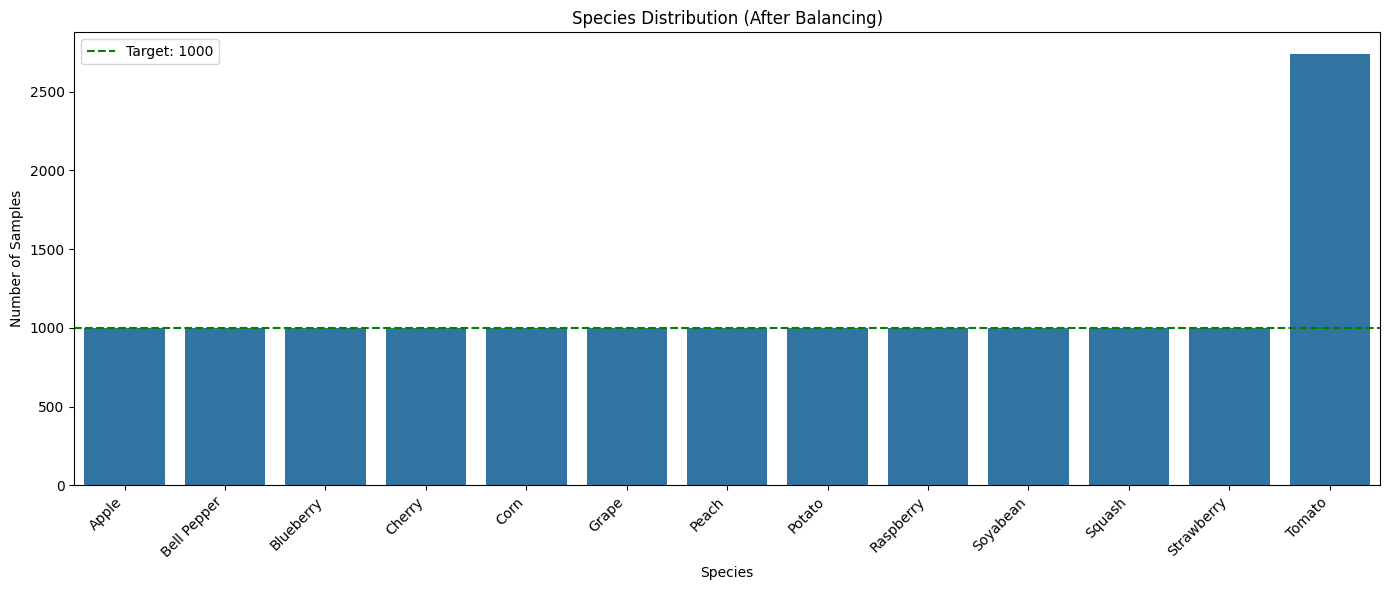

In [31]:
balanced_counts = df_balanced['species'].value_counts()

print("\nFinal species distribution (after balancing):")
for species in sorted(balanced_counts.index):
    count = balanced_counts[species]
    print(f"  {species}: {count} samples")

# Visualize
plt.figure(figsize=(14, 6))
sns.barplot(x=sorted(balanced_counts.index), y=[balanced_counts[s] for s in sorted(balanced_counts.index)])
plt.axhline(y=TARGET_SAMPLES_PER_CLASS, color='g', linestyle='--', label=f'Target: {TARGET_SAMPLES_PER_CLASS}')
plt.title('Species Distribution (After Balancing)')
plt.xlabel('Species')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Step 10: Create Species-to-Index Mapping

In [29]:
# Create species to index mapping (sorted alphabetically for consistency)
species_list = sorted(df_balanced['species'].unique())
species2idx = {species: i for i, species in enumerate(species_list)}

print(f"Species to Index Mapping ({len(species2idx)} classes):")
for species, idx in species2idx.items():
    count = len(df_balanced[df_balanced['species'] == species])
    print(f"  {idx}: {species} ({count} samples)")

Species to Index Mapping (13 classes):
  0: Apple (1000 samples)
  1: Bell Pepper (1000 samples)
  2: Blueberry (1000 samples)
  3: Cherry (1000 samples)
  4: Corn (1000 samples)
  5: Grape (1000 samples)
  6: Peach (1000 samples)
  7: Potato (1000 samples)
  8: Raspberry (1000 samples)
  9: Soyabean (1000 samples)
  10: Squash (1000 samples)
  11: Strawberry (1000 samples)
  12: Tomato (2740 samples)


## Step 9: Calculate Class Weights for YOLO Training

Calculate recommended class weights to handle class imbalance during training.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on species distribution
species_list = sorted(df_balanced['species'].unique())
weights = compute_class_weight(
    'balanced',
    classes=np.array(species_list),
    y=df_balanced['species']
)

class_weights = {species: weight for species, weight in zip(species_list, weights)}

print("Recommended class weights for YOLO training:\n")
print("class_weights = {")
for species in species_list:
    idx = species2idx[species]
    weight = class_weights[species]
    count = len(df_balanced[df_balanced['species'] == species])
    print(f"    {idx}: {weight:.4f},  # {species} ({count} samples)")
print("}")

print(f"\n📊 Weight Statistics:")
print(f"  Min weight: {min(class_weights.values()):.4f} (most common class)")
print(f"  Max weight: {max(class_weights.values()):.4f} (rarest class)")
print(f"  Weight ratio: {max(class_weights.values())/min(class_weights.values()):.2f}x")

print(f"\n💡 How to use in YOLO:")
print(f"   When training your YOLO model, you'll need to configure it to use these weights.")
print(f"   This will make the model penalize mistakes on rare species (like Grape)")
print(f"   more than mistakes on common species (like Tomato).")

Recommended class weights for YOLO training:

class_weights = {
    0: 1.1338,  # Apple (1000 samples)
    1: 1.1338,  # Bell Pepper (1000 samples)
    2: 1.1338,  # Blueberry (1000 samples)
    3: 1.1338,  # Cherry (1000 samples)
    4: 1.1338,  # Corn (1000 samples)
    5: 1.1338,  # Grape (1000 samples)
    6: 1.1338,  # Peach (1000 samples)
    7: 1.1338,  # Potato (1000 samples)
    8: 1.1338,  # Raspberry (1000 samples)
    9: 1.1338,  # Soyabean (1000 samples)
    10: 1.1338,  # Squash (1000 samples)
    11: 1.1338,  # Strawberry (1000 samples)
    12: 0.4138,  # Tomato (2740 samples)
}

📊 Weight Statistics:
  Min weight: 0.4138 (most common class)
  Max weight: 1.1338 (rarest class)
  Weight ratio: 2.74x

💡 How to use in YOLO:
   When training your YOLO model, you'll need to configure it to use these weights.
   This will make the model penalize mistakes on rare species (like Grape)
   more than mistakes on common species (like Tomato).


## Step 11: Create Output Directories

In [30]:
OUTPUT_SPECIES_IMAGES_TRAIN.mkdir(parents=True, exist_ok=True)
OUTPUT_SPECIES_IMAGES_VAL.mkdir(parents=True, exist_ok=True)
OUTPUT_SPECIES_LABELS_TRAIN.mkdir(parents=True, exist_ok=True)
OUTPUT_SPECIES_LABELS_VAL.mkdir(parents=True, exist_ok=True)

print("✓ Output directories created")
print(f"  {OUTPUT_SPECIES_BASE_DIR}")

✓ Output directories created
  /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/species


## Step 12: Convert to YOLO Format and Export Training Data

In [ ]:
def convert_bbox_to_yolo(row):
    x_center = (row['xmin'] + row['xmax']) / 2 / row['width']
    y_center = (row['ymin'] + row['ymax']) / 2 / row['height']
    bbox_width = (row['xmax'] - row['xmin']) / row['width']
    bbox_height = (row['ymax'] - row['ymin']) / row['height']
    return x_center, y_center, bbox_width, bbox_height

def export_to_yolo(df, images_dir, output_images_dir, output_labels_dir, class_mapping):
    exported = 0
    skipped = 0

    for filename, group in df.groupby("filename"):
        try:
            # Check if this is a duplicate (has _dup in name)
            if '_dup' in filename:
                # Get original filename
                original_filename = filename.split('_dup')[0] + Path(filename).suffix
                src = Path(images_dir) / original_filename
            else:
                src = Path(images_dir) / filename

            if not src.exists():
                skipped += 1
                continue

            dst = Path(output_images_dir) / filename
            shutil.copy2(src, dst)

            # Create label file
            label_file = Path(output_labels_dir) / (Path(filename).stem + ".txt")
            with open(label_file, "w") as f:
                for _, row in group.iterrows():
                    cls_idx = class_mapping[row['species']]
                    x_c, y_c, w, h = convert_bbox_to_yolo(row)
                    f.write(f"{cls_idx} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")
            exported += 1
        except Exception as e:
            print(f"Error: {filename} - {e}")
            skipped += 1

    return exported, skipped

print("Exporting TRAINING data to YOLO format...")
exported_train, skipped_train = export_to_yolo(
    df_balanced,
    TRAIN_IMAGES_DIR,
    OUTPUT_SPECIES_IMAGES_TRAIN,
    OUTPUT_SPECIES_LABELS_TRAIN,
    species2idx
)

print(f"\n✓ Training export complete!")
print(f"  Exported: {exported_train} images")
print(f"  Skipped: {skipped_train} images")

Exporting TRAINING data to YOLO format...

✓ Training export complete!
  Exported: 8622 images
  Skipped: 0 images


## Step 13: Export Test/Validation Data

In [ ]:
print("\nExporting TEST data to VALIDATION set...")
exported_val, skipped_val = export_to_yolo(
    df_test_species,
    TEST_IMAGES_DIR,
    OUTPUT_SPECIES_IMAGES_VAL,
    OUTPUT_SPECIES_LABELS_VAL,
    species2idx
)

print(f"\n✓ Validation export complete!")
print(f"  Exported: {exported_val} images")
print(f"  Skipped: {skipped_val} images")

print(f"\n📊 Summary:")
print(f"  Training: {exported_train} images (balanced)")
print(f"  Validation: {exported_val} images (natural distribution)")


Exporting TEST data to VALIDATION set...

✓ Validation export complete!
  Exported: 236 images
  Skipped: 0 images

📊 Summary:
  Training: 8622 images (balanced)
  Validation: 236 images (natural distribution)


## Step 14: Generate YAML Configuration

In [36]:
import yaml

yaml_content = {
    'path': str(OUTPUT_SPECIES_BASE_DIR.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(species2idx),
    'names': {idx: species for species, idx in species2idx.items()}
}

yaml_path = OUTPUT_SPECIES_BASE_DIR / 'dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)

print("✓ YAML configuration created")
print(f"\nLocation: {yaml_path}")
print(f"\nClasses ({len(species2idx)}):")
for idx in sorted(yaml_content['names'].keys()):
    print(f"  {idx}: {yaml_content['names'][idx]}")

✓ YAML configuration created

Location: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/species/dataset.yaml

Classes (13):
  0: Apple
  1: Bell Pepper
  2: Blueberry
  3: Cherry
  4: Corn
  5: Grape
  6: Peach
  7: Potato
  8: Raspberry
  9: Soyabean
  10: Squash
  11: Strawberry
  12: Tomato


## Step 15: Summary

In [37]:
print("=" * 60)
print("SPECIES CLASSIFICATION DATASET READY")
print("=" * 60)
print(f"\n📊 Dataset Statistics:")
print(f"  Total samples: {len(df_balanced)}")
print(f"  Number of species classes: {len(species2idx)}")
print(f"  Target per class: {TARGET_SAMPLES_PER_CLASS}")
print(f"\n  Class distribution:")
for species in sorted(species2idx.keys()):
    count = len(df_balanced[df_balanced['species'] == species])
    print(f"    [{species2idx[species]}] {species}: {count} samples")
print(f"\n📁 Location: {OUTPUT_SPECIES_BASE_DIR}")
print(f"📝 Config: {yaml_path}")
print(f"\n✅ Ready for YOLO training!")
print("=" * 60)

SPECIES CLASSIFICATION DATASET READY

📊 Dataset Statistics:
  Total samples: 14740
  Number of species classes: 13
  Target per class: 1000

  Class distribution:
    [0] Apple: 1000 samples
    [1] Bell Pepper: 1000 samples
    [2] Blueberry: 1000 samples
    [3] Cherry: 1000 samples
    [4] Corn: 1000 samples
    [5] Grape: 1000 samples
    [6] Peach: 1000 samples
    [7] Potato: 1000 samples
    [8] Raspberry: 1000 samples
    [9] Soyabean: 1000 samples
    [10] Squash: 1000 samples
    [11] Strawberry: 1000 samples
    [12] Tomato: 2740 samples

📁 Location: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/species
📝 Config: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/species/dataset.yaml

✅ Ready for YOLO training!
